In [3]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import pandas as pd

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.precision', 3)

In [5]:
from graphviz import Digraph
from time import time
from datetime import timedelta

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [7]:
X = pd.read_csv('../data/processed/X_train', header=0, index_col=0)
y = pd.read_csv('../data/processed/y_train', header=0, index_col=0)
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y[hd_split["target"]])
# # creating hd_train to be used for exploratory data analysis
# hd_train, hd_test = train_test_split(hd, test_size=0.2, random_state=42, stratify=y[hd_split["target"]])
# print(f"Test stratification is: {y_test.mean()}")
# print(f"Train stratification is: {y_train.mean()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y[["target"]])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(f"Test stratification is: {y_test.mean()}")
print(f"Train stratification is: {y_train.mean()}")

(189, 13) (189, 1) (48, 13) (48, 1)
Test stratification is: target    0.458
dtype: float64
Train stratification is: target    0.46
dtype: float64


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# X = scaler.fit_transform(X)

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
# y = y_train.values.ravel()

# Metrics + Baseline
## Playing with Metrics from ML07 lab

In [9]:
results_df = pd.DataFrame(index=['Logistic Regression'],
                          columns=['F-score (cv)', 'Precision (cv)','Recall (cv)', 'Accuracy (cv)'])

In [49]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)

    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

In [11]:
def graphMLP(vars,layers,intercepts):
    """
    Function for plotting the weights of a mlp
    """
    f = Digraph('')
    f.attr(rankdir='LR')
    for i,l in enumerate(layers):
        if i==0:
            for j in range(l.shape[1]):
                for k, v in enumerate(vars):
                    f.edge(v, 'L%dN%d'%(i,j), label=str(l[k,j]))
            f.node('ILI', shape='doublecircle')
            for k in range(intercepts[i].shape[0]):
                f.edge('ILI',
                       'L%dN%d'%(i,k),
                       label=str(intercepts[i][k]))
        else:
            for j in range(l.shape[1]):
                for k in range(layers[i-1].shape[1]):
                    f.edge('L%dN%d'%(i-1,k),
                           'L%dN%d'%(i,j),
                           label=str(l[k,j]))
            f.node('L%dI'%(i-1), shape='doublecircle')
            for k in range(intercepts[i].shape[0]):
                f.edge('L%dI'%(i-1),
                       'L%dN%d'%(i,k),
                       label=str(intercepts[i][k]))

    return f


In [21]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
scores = cross_val_score(logreg, X_train, y_train, cv=5)
y_pred_lr = logreg.predict(X_train)

cross_val_results = pd.DataFrame(cross_validate(logreg, X_train, y_train, cv = 5,
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Logistic Regression',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

confusion(y_train,y_pred_lr)
results_df

LogisticRegression()

predicted,0,1
target,,
0,90,12
1,16,71


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Logistic Regression,0.823,0.836,0.822,0.825
Random Forest,0.839,0.848,0.838,0.841
MLP[1],0.806,0.818,0.804,0.809


In [22]:
rf = RandomForestClassifier(n_estimators=50, random_state=42,max_depth=4)
rf.fit(X_train, y_train)
scores = cross_val_score(rf, X_train, y_train, cv=5)
y_pred_lr = rf.predict(X_train)

cross_val_results = pd.DataFrame(cross_validate(rf , X_train, y_train, cv = 5,
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['Random Forest',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

confusion(y_train,y_pred_lr)
results_df

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=42)

predicted,0,1
target,,
0,98,4
1,12,75


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Logistic Regression,0.823,0.836,0.822,0.825
Random Forest,0.839,0.848,0.838,0.841
MLP[1],0.806,0.818,0.804,0.809


# Neural Network Model

In [42]:
model_nnet = MLPClassifier(hidden_layer_sizes=[1],
                           alpha=0,
                           activation='logistic',
                           max_iter=200,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train, y_train);

y_pred = model_nnet.predict(X_train)

print('Confusion matrix of the TRAIN dataset')
confusion(y_train, y_pred)

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5,
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[1]',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=[1],
              random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,98,4
1,14,73


,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Random Forest,0.839,0.848,0.838,0.841
Logistic Regression,0.823,0.836,0.822,0.825
MLP[1],0.806,0.818,0.804,0.809
"MLP[2,2,2]",0.561,0.526,0.649,0.677


In [34]:
model_nnet.coefs_
model_nnet.intercepts_

[array([[   9.4335218 ],
        [ -99.61191407],
        [-146.57520277],
        [ -48.84175485],
        [ -33.7888432 ],
        [  42.35352118],
        [ -35.54524598],
        [  20.38173087],
        [  18.25579765],
        [-100.23488634],
        [  12.1843939 ],
        [-209.42898076],
        [-107.30828008]]),
 array([[-4.85308393]])]

[array([43.66323493]), array([2.90597251])]

In [33]:
# dataset = X.join(y)
# graphMLP(dataset.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)
pred = pd.Series(y_pred)
true = pd.Series(y_train)

true.name = 'target'
pred.name = 'predicted'
cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
# cm = cm[cm.index]
cm

predicted,0,1
target,,
0,98,4
1,14,73


In [70]:
model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0,
                           activation='logistic',
                           max_iter=1000,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train,y_train);
y_pred = model_nnet.predict(X_train)

print('Confusion matrix of the TRAIN dataset')
# confusion(y_train,y_pred)
# confusion_matrix(y_train, y_pred)
#TODO: It looks like the prediction output is always "0"? Something is wrong with this code but I can't figure out what!!!
# y_pred

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5,
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2]',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

pred = pd.Series(y_pred)
true = pd.Series(y_train)
# pred
# true

true.name = 'target'
pred.name = 'predicted'
cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
cm = cm[cm.index]

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=[2, 2, 2],
              max_iter=1000, random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Random Forest,0.839,0.848,0.838,0.841
Logistic Regression,0.823,0.836,0.822,0.825
MLP[1],0.806,0.818,0.804,0.809
"MLP[2,2,2]",0.804,0.818,0.803,0.809
"MLP[2,2]",0.561,0.526,0.649,0.677
"MLP[2,2,2]-alpha=0.001",0.524,0.481,0.613,0.64


predicted,0
target,
0,102
1,87


KeyError: '[1] not in index'

In [62]:
graphMLP(dataset.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

NameError: name 'dataset' is not defined

In [61]:
model_nnet = MLPClassifier(hidden_layer_sizes=[2,2,2],
                           alpha=0.001,
                           activation='logistic',
                           max_iter=1000,
                           solver='lbfgs',random_state=42)
model_nnet.fit(X_train,y_train);
print('Confusion matrix of the TRAIN dataset')
confusion(y_train,y_pred)

cross_val_results = pd.DataFrame(cross_validate(model_nnet , X_train, y_train, cv = 5,
                                                scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2,2]-alpha=0.001',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=[2, 2, 2],
              max_iter=1000, random_state=42, solver='lbfgs')

Confusion matrix of the TRAIN dataset


predicted,0,1
target,,
0,97,5
1,17,70


/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: Unde

,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Random Forest,0.839,0.848,0.838,0.841
Logistic Regression,0.823,0.836,0.822,0.825
MLP[1],0.806,0.818,0.804,0.809
"MLP[2,2,2]",0.804,0.818,0.803,0.809
"MLP[2,2,2]-alpha=0.001",0.524,0.481,0.613,0.64


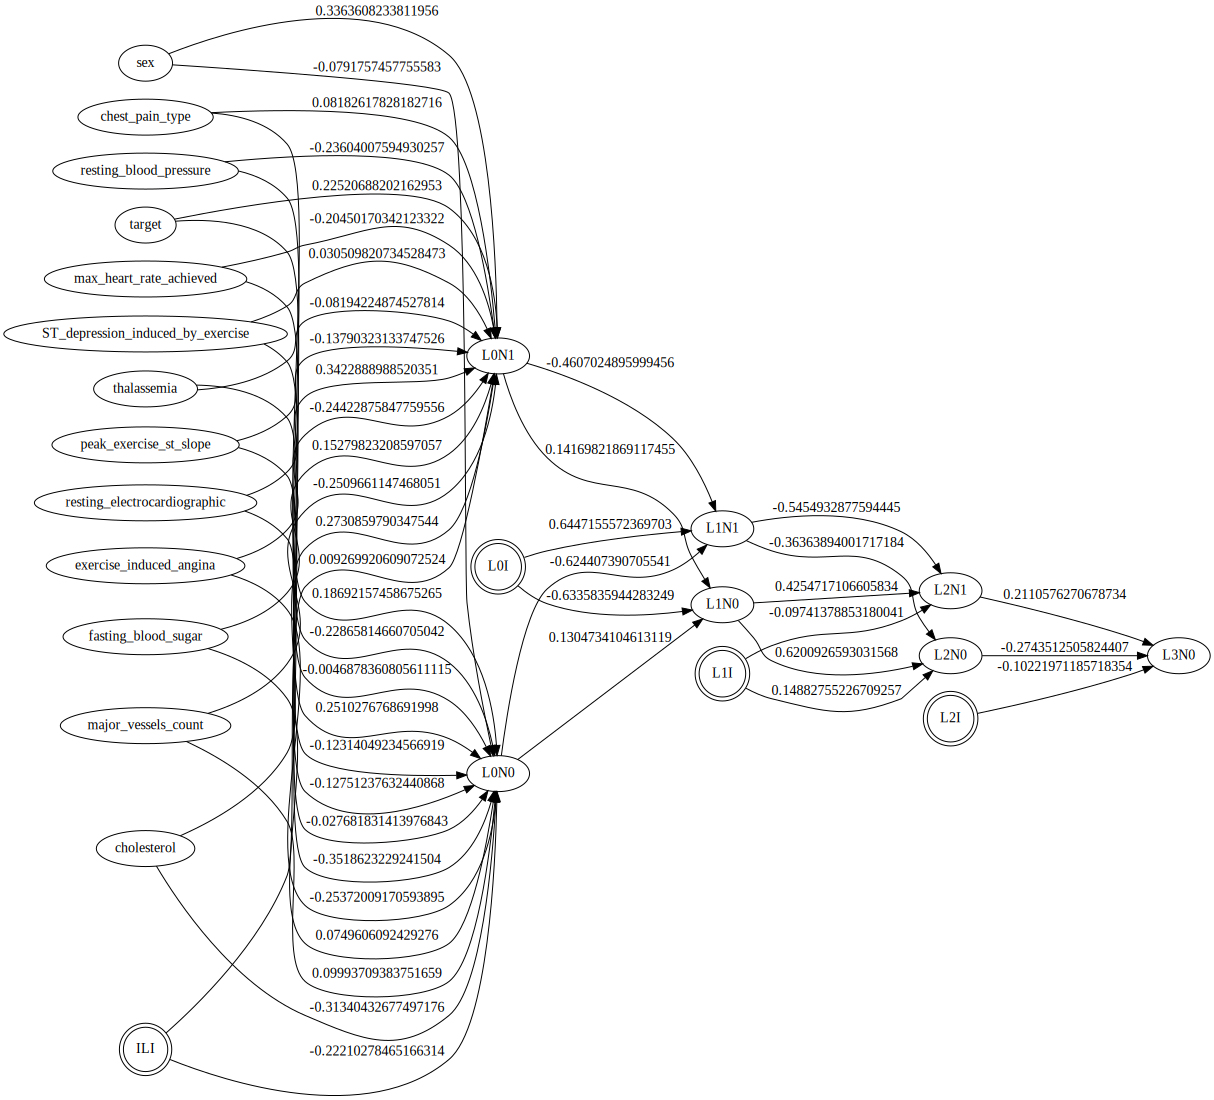

In [46]:
graphMLP(dataset.columns[1:], model_nnet.coefs_, model_nnet.intercepts_)

# Tuning Parameters
Using a grid search

In [47]:
sizes = [2*i for i in range(1,5)]
sizes = sizes + [[2*i,2*i] for i in range(1,5)]
sizes = sizes + [[2*i,2*i, 2*i] for i in range(1,5)]

len(sizes), sizes


decays = [0.00001,0.0001,0.001,0.01,0.1,0.5,1]
len(decays), decays[:10]

(12,
 [2,
  4,
  6,
  8,
  [2, 2],
  [4, 4],
  [6, 6],
  [8, 8],
  [2, 2, 2],
  [4, 4, 4],
  [6, 6, 6],
  [8, 8, 8]])

(7, [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1])

In [51]:
init_time=time()
model_nnet = MLPClassifier(alpha=0,
                           activation='logistic',
                           max_iter=500,
                           solver='lbfgs',
                           random_state=42)

trc = GridSearchCV(estimator=model_nnet,
                   scoring=['f1_macro', 'precision_macro', 'recall_macro', 'accuracy'],
                   param_grid={'hidden_layer_sizes': sizes,
                              'alpha': decays},
                   cv=10,
                   return_train_score=True,
                   refit='f1_macro')

model_10CV = trc.fit(X_train, y_train)
print(timedelta(seconds=(time()-init_time)))

/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/adambroniewski/.local/share/virtualen

0:00:45.356204


/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adambroniewski/.local/share/virtualenvs/Machine-Learning-Project-QM2H3y13/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

In [52]:
pd.DataFrame(model_10CV.cv_results_).loc[:,['param_alpha','param_hidden_layer_sizes',  'mean_test_f1_macro',
                                            'std_test_f1_macro','mean_test_precision_macro', 'std_test_precision_macro',
                                        'mean_test_accuracy','std_test_accuracy',]].sort_values(by='mean_test_f1_macro',
                                                                                                ascending=False).head()

,param_alpha,param_hidden_layer_sizes,mean_test_f1_macro,std_test_f1_macro,mean_test_precision_macro,std_test_precision_macro,mean_test_accuracy,std_test_accuracy
4,0.0,"[2, 2]",0.827,0.083,0.859,0.065,0.836,0.073
74,1,6,0.826,0.055,0.844,0.061,0.830,0.054
79,1,"[8, 8]",0.821,0.056,0.838,0.063,0.825,0.055
78,1,"[6, 6]",0.821,0.056,0.838,0.063,0.825,0.055
75,1,8,0.821,0.056,0.838,0.063,0.825,0.055


In [57]:
model_10CV.best_params_
model_10CV.best_score_

{'alpha': 1e-05, 'hidden_layer_sizes': [2, 2]}

0.8266294506384021

In [59]:
cross_val_results = pd.DataFrame(cross_validate(model_10CV.best_estimator_ , X_train, y_train, cv = 5, scoring = [ 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'] ))

results_df.loc['MLP[2,2]-alpha=0.00001',:] = cross_val_results[['test_f1_macro',
       'test_precision_macro', 'test_recall_macro','test_accuracy']].mean().values

results_df.sort_values(by='F-score (cv)', ascending=False)

,F-score (cv),Precision (cv),Recall (cv),Accuracy (cv)
Random Forest,0.839,0.848,0.838,0.841
Logistic Regression,0.823,0.836,0.822,0.825
MLP[1],0.806,0.818,0.804,0.809
"MLP[2,2]-alpha=0.1",0.805,0.819,0.803,0.809
"MLP[2,2]-alpha=0.00001",0.805,0.819,0.803,0.809
"MLP[2,2,2]",0.561,0.526,0.649,0.677
"MLP[2,2,2]-alpha=0.001",0.535,0.493,0.625,0.65


In [60]:
y_pred = model_10CV.predict(X_test)

confusion(y_test,y_pred)

print(classification_report(y_test, y_pred))

predicted,0,1
target,,
0,23,3
1,4,18


              precision    recall  f1-score   support

           0       0.85      0.88      0.87        26
           1       0.86      0.82      0.84        22

    accuracy                           0.85        48
   macro avg       0.85      0.85      0.85        48
weighted avg       0.85      0.85      0.85        48

